In [3]:
!pip install -q torch-geometric torchinfo

In [4]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from pprint import pprint
import json
from torchinfo import summary
import random
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from tqdm import trange, tqdm
from torch_geometric.data import Data, Batch
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F
from torch_geometric.loader import DataLoader

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
!unzip '/content/drive/MyDrive/School/2025 Spring/Advanced ML/AML Project/Data/new/preprocessed_selected_features.zip'

Archive:  /content/drive/MyDrive/School/2025 Spring/Advanced ML/AML Project/Data/new/preprocessed_selected_features.zip
replace preprocessed_selected_features/test/connectome_matrices.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
seed = 42  # Choose any fixed number
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # If using CUDA

In [8]:
TRAIN_X_PATH = 'preprocessed_selected_features/train/connectome_matrices.csv'
TRAIN_Y_PATH = 'preprocessed_selected_features/train/labels.csv'

In [9]:
train_X_df = pd.read_csv(TRAIN_X_PATH)
train_y_df = pd.read_csv(TRAIN_Y_PATH)
train_X_df.set_index('participant_id', inplace=True)
train_y_df.set_index('participant_id', inplace=True)
train_y_df = train_y_df.reindex(train_X_df.index)

In [10]:
train_X_df.head()

,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,0throw_10thcolumn,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
participant_id,,,,,,,,,,,,,,,,,,,,,
70z8Q2xdTXM3,0.270399,0.580746,0.485892,0.064059,0.617299,0.337467,0.550230,-0.087434,0.579197,0.535364,...,0.305246,0.583610,0.540900,0.228036,0.343643,0.485184,0.019701,0.614717,0.524420,0.404290
WHWymJu6zNZi,0.745668,0.635297,0.560712,0.541223,0.439375,0.473556,0.129684,-0.095509,0.132499,0.314387,...,0.295154,-0.021363,0.000563,-0.119118,0.511165,0.396962,0.201877,0.664817,0.612853,0.557002
4PAQp1M6EyAo,-0.141711,0.503933,0.294476,0.697041,0.840358,0.476623,0.690517,0.215647,0.573338,0.430980,...,0.464666,-0.031043,-0.048386,0.092712,0.464166,0.337855,0.471782,0.504960,0.566427,0.691008
obEacy4Of68I,0.242208,0.829234,0.744090,0.627094,0.756269,0.699015,0.565864,0.463884,0.584879,0.295275,...,0.140506,-0.261833,0.269811,-0.023052,0.490709,0.684443,0.260870,0.373375,0.490076,0.617905
s7WzzDcmDOhF,0.275725,0.675102,0.702433,0.613503,0.804479,0.637771,0.286740,0.404671,0.331130,0.377236,...,-0.223803,0.010372,-0.154615,-0.602806,0.555110,-0.248578,0.254210,0.061103,0.132521,0.119855


In [11]:
train_y_df.head()

,ADHD_Outcome,Sex_F
participant_id,,
70z8Q2xdTXM3,1,0
WHWymJu6zNZi,1,1
4PAQp1M6EyAo,1,1
obEacy4Of68I,1,1
s7WzzDcmDOhF,1,1


In [12]:
def get_upper_triangle_indices(n):
    """Get the upper triangle indices for a square matrix of size n x n."""
    return torch.triu_indices(n, n, offset=1)

def create_pyg_graphs_from_df(df, num_nodes=200):
    """Convert each row of df into a PyTorch Geometric graph with dummy node features."""
    upper_idx = get_upper_triangle_indices(num_nodes)
    edge_list = torch.cat([upper_idx, upper_idx.flip(0)], dim=1)  # undirected edges

    data_list = []
    for i in trange(len(df)):
        edge_weights_upper = torch.tensor(df.iloc[i].values, dtype=torch.float)
        edge_weights = torch.cat([edge_weights_upper, edge_weights_upper])  # symmetric

        x = torch.ones((num_nodes, 1), dtype=torch.float)  # <-- constant node features here

        data = Data(
            x=x,
            edge_index=edge_list,
            edge_attr=edge_weights,
            num_nodes=num_nodes
        )
        data_list.append(data)

    return data_list

In [13]:
def show_adjacency_heatmap(graph, num_nodes=200):

    adj = torch.zeros((num_nodes, num_nodes))

    edge_index = graph.edge_index
    edge_attr = graph.edge_attr

    for i in range(edge_index.size(1)):
        u, v = edge_index[:, i]
        w = edge_attr[i]
        adj[u, v] = w
        adj[v, u] = w  # undirected graph

    # Plot it
    plt.figure(figsize=(5, 4))
    plt.imshow(adj.numpy(), cmap='jet_r', interpolation='nearest')
    plt.colorbar()
    plt.title("Adjacency Matrix Heatmap")
    plt.xlabel("Node")
    plt.ylabel("Node")
    plt.tight_layout()
    plt.show()


In [14]:
graphs = create_pyg_graphs_from_df(train_X_df)

100%|██████████| 1213/1213 [00:00<00:00, 2601.87it/s]


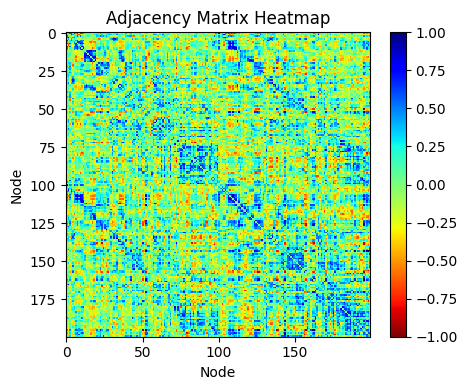

In [15]:
show_adjacency_heatmap(graphs[0])

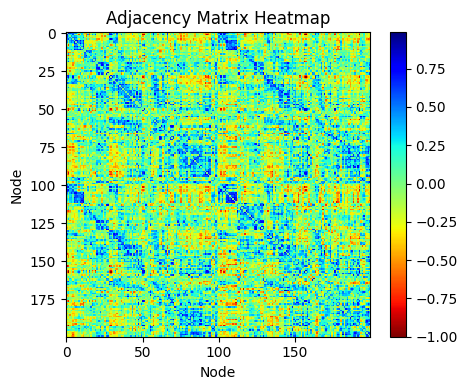

In [16]:
show_adjacency_heatmap(graphs[1])

In [17]:
class Model(nn.Module):
    def __init__(self, layer_dims, dropout=0.5, output_dim=4):
        super(Model, self).__init__()

        self.convs = nn.ModuleList()
        self.acts = nn.ModuleList()
        self.dropouts = nn.ModuleList()

        input_dim = 1  # since we're using constant 1s as node features
        prev_dim = input_dim

        for dim in layer_dims:
            self.convs.append(GCNConv(prev_dim, dim))
            self.acts.append(nn.ReLU())
            self.dropouts.append(nn.Dropout(dropout))
            prev_dim = dim

        self.classifier = nn.Sequential(
            nn.Linear(prev_dim, prev_dim),
            nn.ReLU(),
            nn.Linear(prev_dim, output_dim)
        )

    def forward(self, x, edge_index, edge_weight, batch):
        # x: dummy node features (ones), shape [num_nodes, 1]
        for conv, act, do in zip(self.convs, self.acts, self.dropouts):
            x = conv(x, edge_index, edge_weight=edge_weight)
            x = act(x)
            x = do(x)

        # Global pooling to get graph representation
        x = global_mean_pool(x, batch)

        # Final classification
        return self.classifier(x)

In [18]:
model = Model(layer_dims=[64, 128], output_dim=4)

# Dummy input sizes
num_nodes = 200
num_edges = 19900

x = torch.ones((num_nodes, 1))                         # constant node features
edge_index = torch.randint(0, num_nodes, (2, num_edges))
edge_weight = torch.rand(num_edges)
batch = torch.zeros(num_nodes, dtype=torch.long)       # assume all nodes in one graph

summary(model, input_data=(x, edge_index, edge_weight, batch), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [1, 4]                    --
├─ModuleList: 1-4                        --                        (recursive)
│    └─GCNConv: 2-1                      [200, 64]                 64
│    │    └─Linear: 3-1                  [200, 64]                 64
│    │    └─SumAggregation: 3-2          [200, 64]                 --
├─ModuleList: 1-5                        --                        --
│    └─ReLU: 2-2                         [200, 64]                 --
├─ModuleList: 1-6                        --                        --
│    └─Dropout: 2-3                      [200, 64]                 --
├─ModuleList: 1-4                        --                        (recursive)
│    └─GCNConv: 2-4                      [200, 128]                128
│    │    └─Linear: 3-3                  [200, 128]                8,192
│    │    └─SumAggregation: 3-4          [200, 128]            

In [19]:
y_two_vars = train_y_df.values
y = np.array(y_two_vars[:, 0] * 2 + y_two_vars[:, 1], dtype=np.uint8)

In [20]:
y[:3], y_two_vars[:3]

(array([2, 3, 3], dtype=uint8),
 array([[1, 0],
        [1, 1],
        [1, 1]]))

In [21]:
layer_dims_list = [
    [256, 128, 64],
    [512, 256, 128],
    [512, 256, 128, 64],
    [1024, 512, 256, 128],
    [1024, 512, 256, 128, 64],
    [2048, 1024, 512, 256],
    [2048, 1024, 512, 256, 128],
    [2048, 1024, 512, 256, 128, 64],
]
dropouts = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

In [22]:
criterion = nn.CrossEntropyLoss()

In [23]:
seed = 42  # Choose any fixed number
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # If using CUDA

In [24]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [29]:
num_epochs = 200
batch_size = 32

results = {"-".join(map(str, layer_dims)): {} for layer_dims in layer_dims_list}
epoch_history = {"-".join(map(str, layer_dims)): {} for layer_dims in layer_dims_list}

y = np.array(y)

for layer_dims in layer_dims_list:
    for dropout in dropouts:
        print("complexity:", layer_dims, "dropout rate:", dropout)
        f1_scores = []
        best_epochs = []

        for fold, (train_index, test_index) in enumerate(kf.split(graphs)):
            train_graphs = [graphs[i] for i in train_index]
            test_graphs = [graphs[i] for i in test_index]
            y_train = y[train_index]
            y_test = y[test_index]

            # Assign labels to each graph
            for i, g in enumerate(train_graphs):
                g.y = torch.tensor(y_train[i], dtype=torch.long)
            for i, g in enumerate(test_graphs):
                g.y = torch.tensor(y_test[i], dtype=torch.long)

            # DataLoaders
            train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)

            model = Model(layer_dims=layer_dims, dropout=dropout, output_dim=4).to(device)
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            best_test_loss = float("inf")
            best_f1 = 0.0
            best_epoch = 0

            for epoch in trange(num_epochs):
                model.train()
                for batch in train_loader:
                    batch = batch.to(device)
                    optimizer.zero_grad()
                    out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
                    loss = F.cross_entropy(out, batch.y)
                    loss.backward()
                    optimizer.step()

                # Evaluate
                model.eval()
                all_preds, all_labels = [], []
                total_test_loss = 0.0
                with torch.no_grad():
                    for batch in test_loader:
                        batch = batch.to(device)
                        out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
                        loss = F.cross_entropy(out, batch.y)
                        total_test_loss += loss.item()
                        preds = out.argmax(dim=1).cpu().numpy()
                        all_preds.extend(preds)
                        all_labels.extend(batch.y.cpu().numpy())

                f1 = f1_score(all_labels, all_preds, average="macro")

                if total_test_loss < best_test_loss:
                    best_test_loss = total_test_loss
                    best_f1 = f1
                    best_epoch = epoch

            f1_scores.append(float(best_f1))
            best_epochs.append(best_epoch)

        print(f1_scores)
        results["-".join(map(str, layer_dims))][dropout] = f1_scores
        epoch_history["-".join(map(str, layer_dims))][dropout] = best_epochs

complexity: [16, 8] dropout rate: 0.0


  1%|          | 2/200 [00:50<1:22:42, 25.06s/it]


KeyboardInterrupt: 

In [ ]:
results_json = json.dumps(results, indent=4)
print(results_json)

{
    "64-32-16": {
        "0.0": [
            0.18174100941503318,
            0.1558073654390935,
            0.1725067385444744,
            0.16056338028169015,
            0.2526053074384982
        ]
    },
    "128-64-32": {
        "0.0": [
            0.16960317460317462,
            0.19521286356546472,
            0.2100162726198324,
            0.1601123595505618,
            0.26139988196725783
        ]
    },
    "128-64-32-16": {
        "0.0": [
            0.22595870206489677,
            0.25507243516362055,
            0.1725067385444744,
            0.23682966286718182,
            0.16574585635359115
        ]
    },
    "256-128-64-32": {
        "0.0": [
            0.16568732193732194,
            0.2556390977443609,
            0.2575507679620658,
            0.2293488601452311,
            0.2501594896331738
        ]
    },
    "256-128-64-32-16": {
        "0.0": [
            0.15482954545454544,
            0.1558073654390935,
            0.212354124748

In [ ]:
full_results = {}
summary_results = {}
final_epoch_history = {}

for layer_dims in results.keys():
    for dropout in results[layer_dims].keys():
        full_results[layer_dims+'-'+str(dropout)] = results[layer_dims][dropout]
        summary_results[layer_dims+'-'+str(dropout)] = float(np.mean(results[layer_dims][dropout]))
        final_epoch_history[layer_dims+'-'+str(dropout)] = epoch_history[layer_dims][dropout]

summary_results = dict(sorted(summary_results.items(), key=lambda item: item[1], reverse=True))
keys = list(summary_results.keys())
final_epoch_history = dict(sorted(final_epoch_history.items(), key=lambda item: keys.index(item[0]), reverse=False))


with open("full_results.json", "w") as f:
    json.dump(results, f, indent=4)


with open("summary_results.json", "w") as f:
    json.dump(summary_results, f, indent=4)


with open("epoch_history.json", "w") as f:
    json.dump(final_epoch_history, f, indent=4)

In [ ]:
best_layer_dims, best_dropout, n_epochs = [256,128,64,32], 0, 20

In [ ]:
model = Model(
    layer_dims=best_layer_dims, dropout=best_dropout, output_dim=4
)
optimizer = optim.Adam(model.parameters(), lr=0.001)
for i, g in enumerate(graphs):
    g.y = torch.tensor(y[i], dtype=torch.long)
train_loader = DataLoader(graphs, batch_size=batch_size, shuffle=True)

model.train()
for epoch in trange(num_epochs):
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        loss = F.cross_entropy(out, batch.y)
        loss.backward()
        optimizer.step()

100%|██████████| 20/20 [00:06<00:00,  2.94it/s]


In [ ]:
torch.save(model.state_dict(), "256-128-64-32-0.0.pth")

In [ ]:
model.eval()
all_preds = []
with torch.no_grad():
    for batch in train_loader:
        batch = batch.to(device)
        yhat = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        predicted = torch.argmax(yhat, 1)
        all_preds.extend(predicted.cpu().numpy())
f1 = f1_score(y, all_preds, average="macro")
print(f1)

0.34458596554316834
